## Analyze one layer  

Objective: Read reconstructed data for one scan layer, then:  
1. Binarize the volume (1 is void-space and 0 is metal-space)  
2. Connected components step (find connected voxels that form individual voids and label them)  
3. Extract a collection *Voids*  
4. On Voids, find max feret diameter, size, local number density  
5. Save the voids data for plotting  
6. Export ply mesh for visualization  

## File Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tomo2mesh import DataFile
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.porosity.params_3dunet import *
from tomo2mesh.misc.ellipse_fitting import *
import cc3d
from scipy.ndimage import median_filter
import statistics as stat 
from tabulate import tabulate
from tomo2mesh.structures.voids import Voids
from tomo2mesh.structures.voids import Surface
from tomo2mesh.misc.voxel_processing import TimerCPU

2022-08-05 16:20:56.664423: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
#Change file paths here as necessary for each sample, layer, and/or model

fpath = '/data02/chris/data/recons/am316_ss_id105_2_c_rec_1x1_uint16_tiff_cropped_4001pix'
fpath_seg = '/data02/chris/data/binarized/AM316_L201_fs_tomo_L6'
model_path = '/data02/MyArchive/tomo_datasets/data_porosity_mapping_paper/models_unet'
model_tag = "M_a07" #M_a07 was used for vast majority
bin_size = 2  #2 was used for vast majority

In [2]:
#For uploading the reconstructed file for viewing
#Skip this step if the file has already been fully segmented as desired

dfile = DataFile(fpath, tiff = True)

NameError: name 'DataFile' is not defined

In [4]:
#For uploading the binarized data

dfile_seg = DataFile(fpath_seg, tiff = True)


##################################################
Found existing tiff folder: AM316_L201_fs_tomo_L6
Dataset shape: (448, 2592, 2592)


## File Checking
This step can be skipped if ML and slicing parameters have already been determined

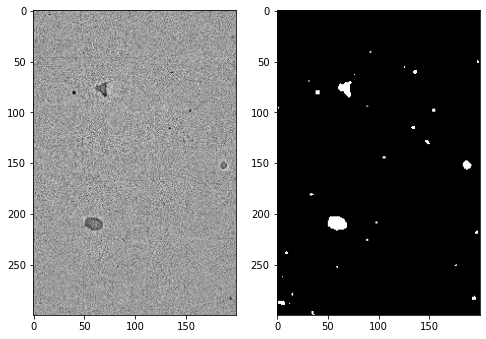

In [13]:
#For viewing horizontal slices
    
fig, ax = plt.subplots(1,2, figsize = (8, 8))
#s = (slice(1500,2000), slice(2800,3000))
s = (slice(400,700), slice(400,600))  #Would have to be adjusted for different layers and/or bin sizes
z_val = 100   #Will have to be adjusted for different needs
ax[0].imshow(dfile.read_slice(axis = 0, slice_idx = bin_size*z_val)[::bin_size,::bin_size][s], cmap = 'gray')
ax[1].imshow(dfile_seg.read_slice(axis = 0, slice_idx = z_val)[s], cmap = 'gray')


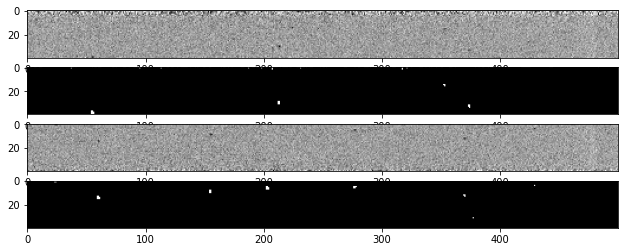

In [21]:
#For vertical slicing
fig, ax = plt.subplots(4,1,figsize = (32, 4))
x_val = 800  #2200 for most files
s1 = (slice(0,40), slice(300,800))
s2 = (slice(216,256), slice(300,800)) #(slice(410,448), slice(1300,1800)) #for most files
ax[0].imshow(dfile.read_full(bin_size)[::,::bin_size,x_val*bin_size][s1], cmap = 'gray')
ax[1].imshow(dfile_seg.read_full(1)[::,::,x_val][s1], cmap = 'gray')
ax[2].imshow(dfile.read_full(bin_size)[::,::bin_size,x_val*bin_size][s2], cmap = 'gray')
ax[3].imshow(dfile_seg.read_full(1)[::,::,x_val][s2], cmap = 'gray')

## File Processing

In [5]:
#This reads the segmented file and cuts off the noise from s2 of vertical slicing
Vb = dfile_seg.read_full()[20::,::,::] #Usually 20
Vb.shape

(428, 2592, 2592)

In [6]:
#This connects the voids and cuts off the noise from s1 of vertical slicing
Vl = cc3d.connected_components(Vb)[:Vb.shape[0]-15:,::,::] #Usually -15
Vl.shape

(413, 2592, 2592)

In [7]:
voids = Voids().count_voids(Vl, 4, 3) # b = 4 and dust_thresh = 3

	STAT: voids found - 60553


In [8]:
voids.select_by_size(10, pixel_size_um = 1.17,sel_type='geq')  #Change threshold um here by changing number in first position
print('\t'"STAT: voids found after thresholding - ",len(voids["sizes"]))

	STAT: size thres: 2.14 pixel length for 10.00 um threshold
	STAT: voids found after thresholding -  60519


In [9]:
voids.vol_shape

(413, 2592, 2592)

## Paraview File Generation

In [10]:
#For generating a sizes .ply

#The sizes color scaling uses logarithm of the volume within a void.
#This is represented by np.log(self["sizes"]+1.0e-12)
#In this expression, the "sizes" is the total volume enclosed.

mesh = voids.export_void_mesh_mproc("sizes", edge_thresh=1.0)
mesh.write_ply("/data02/chris/data/ply/L201_L6_sizes.ply")

	TIME: compute void mesh 39.80 secs


In [11]:
#For generating a feret diameter .ply

#By changing the scalar in Paraview, you can change the output from
#1. The baseline feret diameter
#X. norm_dia, value = 1 is roughly spherical and > 1 is crack-like
#Y. theta, angle along XY plane
#Z. phi, angle w.r.t. Z axis

mesh = voids.export_void_mesh_mproc("max_feret", edge_thresh=1.0)
mesh.write_ply("/data02/chris/data/ply/L201_L6_max_feret.ply")

	TIME: calculate max feret diameter 29.76 secs
	TIME: compute void mesh 69.49 secs


In [12]:
#For generating number density .ply

#By changing the scalar in Paraview, you can change the output from
#1. The baseline number density
#2. Unscaled voxel volume sizes

radius_val = 50 #The voxel radius of the observed space sphere around each void used for counting number density
voids.calc_number_density(radius_val/1.172)
mesh = voids.export_void_mesh_mproc("number_density", edge_thresh=1.0)
mesh.write_ply("/data02/chris/data/ply/L201_L6_numberdensity.ply")

	TIME: calculate number density 40.19 secs
	TIME: compute void mesh 40.70 secs


In [91]:
#For generating the layer surface .ply


# voids['x_voids'] = voids['x_boundary']
# len(voids['x_voids'])
# voids['sizes']=voids['sizes'][0:413]
# mesh = voids.export_void_mesh_mproc("sizes", edge_thresh=1.0)
# mesh.write_ply("/data02/chris/data/ply/test_surface.ply")


## Data Generation

This will a data table of the following void properties for the current layer:
- Diameter
- Equivalent Sphere
- Normalized Diameter
- Theta
- Phi

It can calculate porosity for the full layer

And, it can be used to generate the ellipticity data table

In [31]:
#Conversion of voxel to micron

voxel_len = 1.172 #microns per voxel length
voxel_conv = voxel_len**3

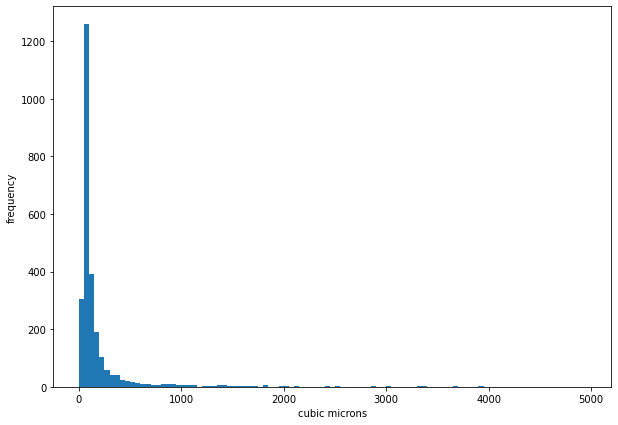

Largest void by volume: 17999.63 cubic microns
Total voids counted:  2657


In [32]:
# Creating void distribution histogram

fig, ax = plt.subplots(figsize =(10, 7))
binwidth = 50
ax.hist(voids["sizes"]*voxel_conv, bins=range(0, 5000, binwidth))
plt.xlabel("cubic microns")
plt.ylabel("frequency")
plt.show()
print("Largest void by volume: " + str(float(f'{max(voids["sizes"]*voxel_conv):.2f}')) + " cubic microns")
print("Total voids counted: ",len(voids["sizes"]))

In [33]:
#For calculating the the data

voids.calc_max_feret_dm()

#The micron radius of the observed space sphere around each void used for counting number density
radius_val = 50 
voids.calc_number_density(radius_val/voxel_len) 

	TIME: calculate max feret diameter 1.08 secs
	TIME: calculate number density 0.05 secs


In [34]:
#Writing of data

sizes_mean = stat.mean(voids["sizes"]*voxel_conv); sizes_median = stat.median(voids["sizes"]*voxel_conv); sizes_stdev = stat.stdev(voids["sizes"]*voxel_conv); sizes_max = float(f'{max(voids["sizes"]*voxel_conv):.2f}')
num_dens_mean = stat.mean(voids['number_density']); num_dens_median = stat.median(voids['number_density']); num_dens_stdev = stat.stdev(voids['number_density']); num_dens_max = max(voids['number_density'])
dia_mean = stat.mean(voids["max_feret"]["dia"]*voxel_len); dia_median = stat.median(voids["max_feret"]["dia"]*voxel_len); dia_stdev = stat.stdev(voids["max_feret"]["dia"]*voxel_len); dia_max = float(f'{max(voids["max_feret"]["dia"]*voxel_len):.2f}')
eq_sph_mean = stat.mean(voids["max_feret"]["eq_sph"]*voxel_len); eq_sph_median = stat.median(voids["max_feret"]["eq_sph"]*voxel_len); eq_sph_stdev = stat.stdev(voids["max_feret"]["eq_sph"]*voxel_len); eq_sph_max = float(f'{max(voids["max_feret"]["eq_sph"]*voxel_len):.2f}')
norm_dia_mean = stat.mean(voids["max_feret"]["norm_dia"]); norm_dia_median = stat.median(voids["max_feret"]["norm_dia"]) ;norm_dia_stdev = stat.stdev(voids["max_feret"]["norm_dia"]); norm_dia_max = float(f'{max(voids["max_feret"]["norm_dia"]):.2f}')
theta_mean = stat.mean(voids["max_feret"]["theta"]); theta_median = stat.median(voids["max_feret"]["theta"]); theta_stdev = stat.stdev(voids["max_feret"]["theta"])
phi_mean = stat.mean(voids["max_feret"]["phi"]); phi_median = stat.median(voids["max_feret"]["phi"]); phi_stdev = stat.stdev(voids["max_feret"]["phi"])

In [35]:
#Generating a table

info = {'Measurement': ['Volume (cubic microns)', 'Number Density, micron radius = ' + str(radius_val), 'Feret Diameter (cubic microns)', 'Equivalent Sphere Diameter (microns)', 'Normalized Diameter (Feret/eq_sphere)','Theta, angle along XY plane','Phi, angle w.r.t z-axis'], 'Mean': [sizes_mean, num_dens_mean, dia_mean, eq_sph_mean, norm_dia_mean, theta_mean, phi_mean], 'Median': [sizes_median, num_dens_median, dia_median, eq_sph_median, norm_dia_median, theta_median, phi_median],'Std. Dev.': [sizes_stdev, num_dens_stdev, dia_stdev, eq_sph_median, norm_dia_stdev, theta_stdev, phi_stdev],'Maximum': [sizes_max, num_dens_max, dia_max, eq_sph_max, norm_dia_max, "--", "--"]}
print(tabulate(info, headers='keys', tablefmt='fancy_grid'))

╒═══════════════════════════════════════╤═══════════╤══════════╤═════════════╤═══════════╕
│ Measurement                           │      Mean │   Median │   Std. Dev. │ Maximum   │
╞═══════════════════════════════════════╪═══════════╪══════════╪═════════════╪═══════════╡
│ Volume (cubic microns)                │ 272.052   │ 85.3215  │  856.643    │ 17999.63  │
├───────────────────────────────────────┼───────────┼──────────┼─────────────┼───────────┤
│ Number Density, micron radius = 50    │   3.65977 │  3       │    2.56103  │ 21        │
├───────────────────────────────────────┼───────────┼──────────┼─────────────┼───────────┤
│ Feret Diameter (cubic microns)        │  10.2083  │  7.032   │    8.43456  │ 83.15     │
├───────────────────────────────────────┼───────────┼──────────┼─────────────┼───────────┤
│ Equivalent Sphere Diameter (microns)  │   6.44367 │  5.46202 │    5.46202  │ 32.52     │
├───────────────────────────────────────┼───────────┼──────────┼─────────────┼───────────┤

In [36]:
#Full layer porosity calculation
#This works by counting all the solid space within the layer, adding in the void space, and then dividing the void space by that sum

void_vol = sum(voids["sizes"])
cylinder_vol = np.count_nonzero(Vl == 0) + void_vol
porosity = void_vol/cylinder_vol*100
print("Layer porosity of " + str(float(f'{porosity:.3f}')) + "%")

Layer porosity of 0.19%


In [ ]:
#Note: Changing threshold of 10um to 20um moved porosity from 1.583 to 1.554% for CGL-15_L6

In [37]:
#For calculating the ellipticity
#Creates a (2, # of voids) array arranged by ellipticity equ., ellipticity polar
#This takes 25 min to >1 hour to run depending on number of voids

ellip_data=np.zeros([2,len(voids["x_voids"])])
for i in range(len(voids["x_voids"])):
    ellip_data[:,i]=(max_ellip_rad(voids["x_voids"][i]))
    
ellip_equ_mean = stat.mean(ellip_data[0])
ellip_equ_median = stat.median(ellip_data[0])
ellip_equ_stdev = stat.stdev(ellip_data[0])
ellip_polar_mean = stat.mean(ellip_data[1])
ellip_polar_median = stat.median(ellip_data[1])
ellip_polar_stdev = stat.stdev(ellip_data[1])

In [38]:
#Generating an ellipticity table

info = {'Measurement': ['Ellipticity (Equ.)', 'Ellipticity (Polar)'], 'Mean': [ellip_equ_mean, ellip_polar_mean], 'Median': [ellip_equ_median, ellip_polar_median],'Std. Dev.': [ellip_equ_stdev, ellip_polar_stdev]}
print(tabulate(info, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════╤══════════╤══════════╤═════════════╕
│ Measurement         │     Mean │   Median │   Std. Dev. │
╞═════════════════════╪══════════╪══════════╪═════════════╡
│ Ellipticity (Equ.)  │ 0.502954 │ 0.482761 │    0.231055 │
├─────────────────────┼──────────┼──────────┼─────────────┤
│ Ellipticity (Polar) │ 0.661279 │ 0.654396 │    0.196072 │
╘═════════════════════╧══════════╧══════════╧═════════════╛
